In [1]:
import pyroomacoustics as pra
from pyroomacoustics.doa import MUSIC
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from src.file_io import load_signal_from_wav, write_signal_to_wav

# MUSIC

## Common

In [2]:
def plot_music_spectrum(doa):
    estimated_angles = doa.grid.azimuth
    music_spectrum = doa.grid.values
    plt.figure(figsize=(12, 5))

    # Plot the MUSIC spectrum in polar coordinates
    plt.subplot(1, 2, 1, projection="polar")
    plt.polar(estimated_angles, music_spectrum)
    plt.title("MUSIC Spectrum (Polar Coordinates)")
    plt.grid(True)

    # Plot the MUSIC spectrum in Cartesian coordinates
    plt.subplot(1, 2, 2)
    plt.plot(np.rad2deg(estimated_angles), music_spectrum)  # Convert radians to degrees
    plt.title("MUSIC Spectrum (Cartesian Coordinates)")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Magnitude")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## 2D SSL with a Single Source

(<Figure size 640x480 with 1 Axes>, <Axes: >)

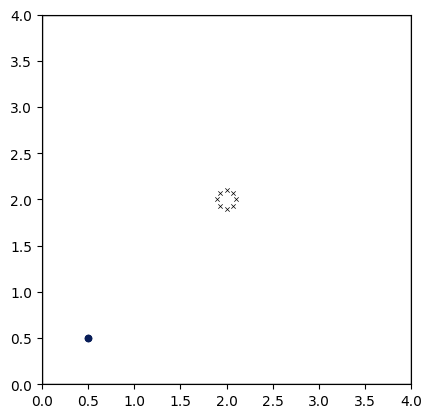

In [3]:
room_dim = [4, 4]
corners = np.array([[0, 0], [0, room_dim[1]], room_dim, [room_dim[0], 0]]).T  # [x,y]

# 2次元の部屋を作成
room = pra.Room.from_corners(
    corners,
    fs=16000,
    max_order=0,
)

# 音源の位置を定義
sources_positions = np.array([[0.5, 0.5]])

# 音源を部屋に追加
signal = load_signal_from_wav("../data/processed/propeller/p2000_2/dst.wav", room.fs)
samples_per_source = len(signal) // len(sources_positions)
for i, pos in enumerate(sources_positions):
    room.add_source(pos, signal=signal[samples_per_source * i:samples_per_source * (i + 1)])

# マイクロホンアレイの位置を計算
mic_positions = pra.circular_2D_array(center=[2.,2.], M=8, phi0=0, radius=0.1)

# マイクロホンアレイを部屋に追加
mic_array = pra.MicrophoneArray(
    mic_positions,  # マイクロホンの位置を更新
    room.fs,  # サンプリング周波数
)
room.add_microphone_array(mic_array)

room.plot()

In [4]:
room.simulate(snr=10)
simulated_signals = room.mic_array.signals
write_signal_to_wav(simulated_signals, "hoge.wav", room.fs)
simulated_signals.shape

(8, 320184)

In [5]:
# FFTの長さとホップサイズを定義
nfft = 512
hop_size = nfft // 2

# シミュレートされた信号をフレームに分割し、FFTを計算
num_frames = (simulated_signals.shape[1] - nfft) // hop_size + 1
X = np.empty((simulated_signals.shape[0], nfft // 2 + 1, num_frames), dtype=complex)

for t in range(num_frames):
    frame = simulated_signals[:, t*hop_size:t*hop_size+nfft]
    X[:, :, t] = np.fft.rfft(frame, n=nfft)

推定された音源の方向（ラジアン）: [-2.35400675]
推定された音源の方向（度）: [-134.87465181]


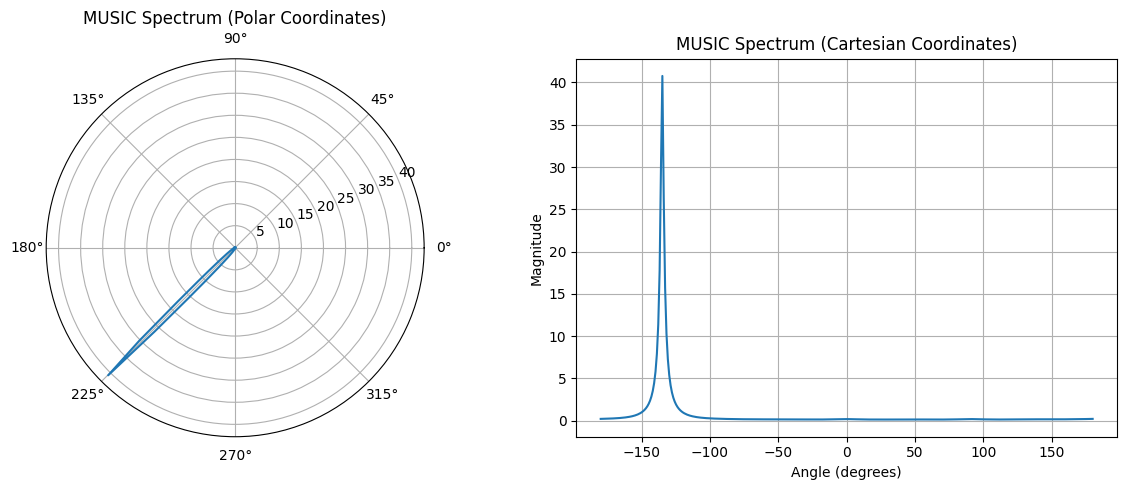

In [6]:
# MUSICインスタンスを作成
doa = MUSIC(
    L=mic_positions,
    fs=room.fs,
    nfft=nfft,
    c=343.0,
    num_src=len(sources_positions),
    mode="far",
    azimuth=np.linspace(-np.pi, np.pi, 360)
)

# 3次元配列を使用してMUSIC法を適用
doa.locate_sources(X, freq_range=[300, 3500])

# 推定された方向を取得
estimated_angles = doa.azimuth_recon

print("推定された音源の方向（ラジアン）:", estimated_angles)
print("推定された音源の方向（度）:", np.rad2deg(estimated_angles))
plot_music_spectrum(doa)

円状だと、線状のように線対称で角度が不明な場合とは異なり、角度が明らかになる

## 2D SSL with Multiple Sources

(<Figure size 640x480 with 1 Axes>, <Axes: >)

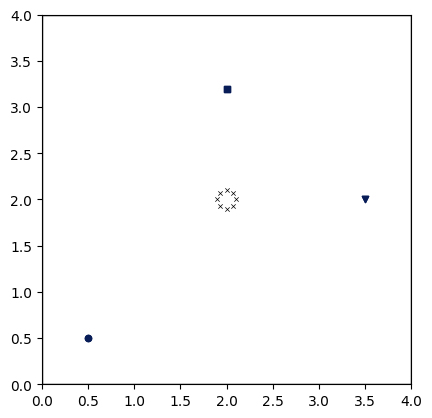

In [7]:
room_dim = [4, 4]
corners = np.array([[0, 0], [0, room_dim[1]], room_dim, [room_dim[0], 0]]).T  # [x,y]

# 2次元の部屋を作成
room = pra.Room.from_corners(
    corners,
    fs=16000,
    max_order=0,
)

# 音源の位置を定義
sources_positions = np.array([[0.5, 0.5], [2, 3.2], [3.5, 2]])

# 音源を部屋に追加
signal = load_signal_from_wav("../data/processed/propeller/p2000_2/dst.wav", room.fs)
samples_per_source = len(signal) // len(sources_positions)
for i, pos in enumerate(sources_positions):
    room.add_source(pos, signal=signal[samples_per_source * i:samples_per_source * (i + 1)])

# マイクロホンアレイの位置を計算
mic_positions = pra.circular_2D_array(center=[2.,2.], M=8, phi0=0, radius=0.1)

# マイクロホンアレイを部屋に追加
mic_array = pra.MicrophoneArray(mic_positions, room.fs)
room.add_microphone_array(mic_array)

room.plot()

In [8]:
room.simulate(snr=90)
simulated_signals = room.mic_array.signals
write_signal_to_wav(simulated_signals, "hoge.wav", room.fs)
simulated_signals.shape

(8, 106850)

In [9]:
# FFTの長さとホップサイズを定義
nfft = 512
hop_size = nfft // 2

# シミュレートされた信号をフレームに分割し、FFTを計算
num_frames = (simulated_signals.shape[1] - nfft) // hop_size + 1
X = np.empty((simulated_signals.shape[0], nfft // 2 + 1, num_frames), dtype=complex)

for t in range(num_frames):
    frame = simulated_signals[:, t*hop_size:t*hop_size+nfft]
    X[:, :, t] = np.fft.rfft(frame, n=nfft)

推定された音源の方向（ラジアン）: [ 1.56642085  0.00875095 -2.35400675]
推定された音源の方向（度）: [  89.74930362    0.50139276 -134.87465181]


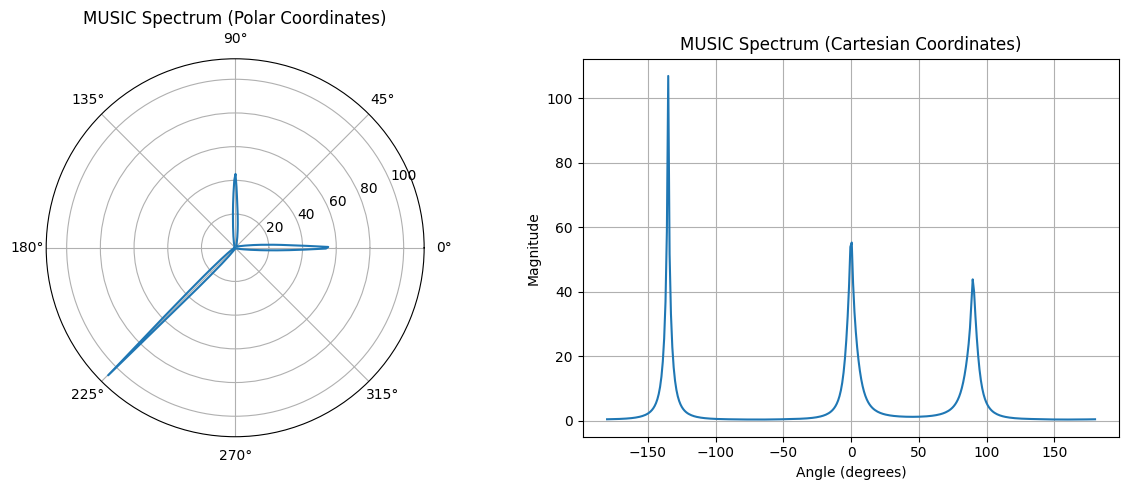

In [10]:
# MUSICインスタンスを作成
doa = MUSIC(
    L=mic_positions,
    fs=room.fs,
    nfft=nfft,
    c=343.0,
    num_src=len(sources_positions),
    mode="near",
    azimuth=np.linspace(-np.pi, np.pi, 360)
)

# 3次元配列を使用してMUSIC法を適用
doa.locate_sources(X, freq_range=[300, 3500])

# 推定された方向を取得
estimated_angles = doa.azimuth_recon

print("推定された音源の方向（ラジアン）:", estimated_angles)
print("推定された音源の方向（度）:", np.rad2deg(estimated_angles))
plot_music_spectrum(doa)

円状だと複数音源の定位も余裕だった

### SNR を小さくしてみる

推定された音源の方向（ラジアン）: [-0.00875095  1.56642085 -2.35400675]
推定された音源の方向（度）: [  -0.50139276   89.74930362 -134.87465181]


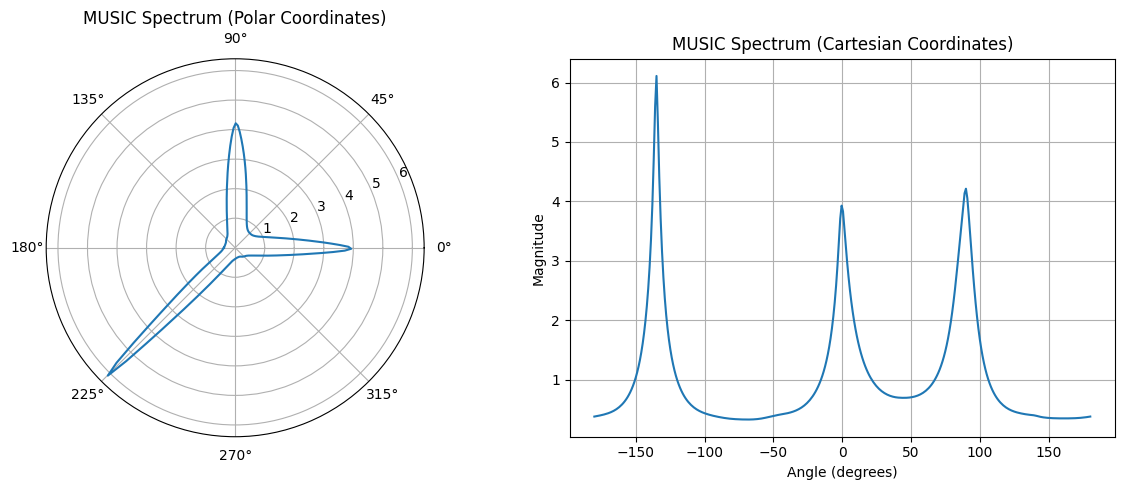

In [11]:
room.simulate(snr=-5)
simulated_signals = room.mic_array.signals
write_signal_to_wav(simulated_signals, "hoge.wav", room.fs)

# FFTの長さとホップサイズを定義
nfft = 512
hop_size = nfft // 2

# シミュレートされた信号をフレームに分割し、FFTを計算
num_frames = (simulated_signals.shape[1] - nfft) // hop_size + 1
X = np.empty((simulated_signals.shape[0], nfft // 2 + 1, num_frames), dtype=complex)

for t in range(num_frames):
    frame = simulated_signals[:, t*hop_size:t*hop_size+nfft]
    X[:, :, t] = np.fft.rfft(frame, n=nfft)

# MUSICインスタンスを作成
doa = MUSIC(
    L=mic_positions,
    fs=room.fs,
    nfft=nfft,
    c=343.0,
    num_src=len(sources_positions),
    mode="near",
    azimuth=np.linspace(-np.pi, np.pi, 360)
)

# 3次元配列を使用してMUSIC法を適用
doa.locate_sources(X, freq_range=[300, 3500])

# 推定された方向を取得
estimated_angles = doa.azimuth_recon

print("推定された音源の方向（ラジアン）:", estimated_angles)
print("推定された音源の方向（度）:", np.rad2deg(estimated_angles))
plot_music_spectrum(doa)

SNR が小さくなっても定位ができている

### 半径を大きくしてみる

(<Figure size 640x480 with 1 Axes>, <Axes: >)

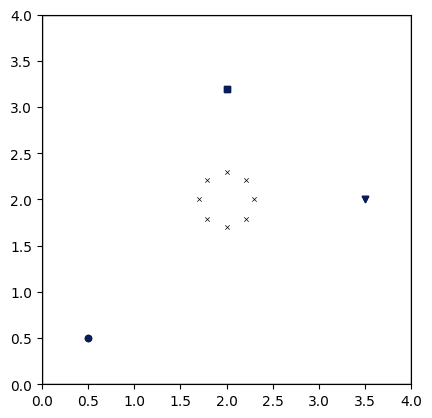

In [12]:
room_dim = [4, 4]
corners = np.array([[0, 0], [0, room_dim[1]], room_dim, [room_dim[0], 0]]).T  # [x,y]

# 2次元の部屋を作成
room = pra.Room.from_corners(
    corners,
    fs=16000,
    max_order=0,
)

# 音源の位置を定義
sources_positions = np.array([[0.5, 0.5], [2, 3.2], [3.5, 2]])

# 音源を部屋に追加
signal = load_signal_from_wav("../data/processed/propeller/p2000_2/dst.wav", room.fs)
samples_per_source = len(signal) // len(sources_positions)
for i, pos in enumerate(sources_positions):
    room.add_source(pos, signal=signal[samples_per_source * i:samples_per_source * (i + 1)])

# マイクロホンアレイの位置を計算
mic_positions = pra.circular_2D_array(center=[2.,2.], M=8, phi0=0, radius=0.3)

# マイクロホンアレイを部屋に追加
mic_array = pra.MicrophoneArray(mic_positions, room.fs)
room.add_microphone_array(mic_array)

room.plot()

推定された音源の方向（ラジアン）: [ 1.56642085 -0.00875095 -2.35400675]
推定された音源の方向（度）: [  89.74930362   -0.50139276 -134.87465181]


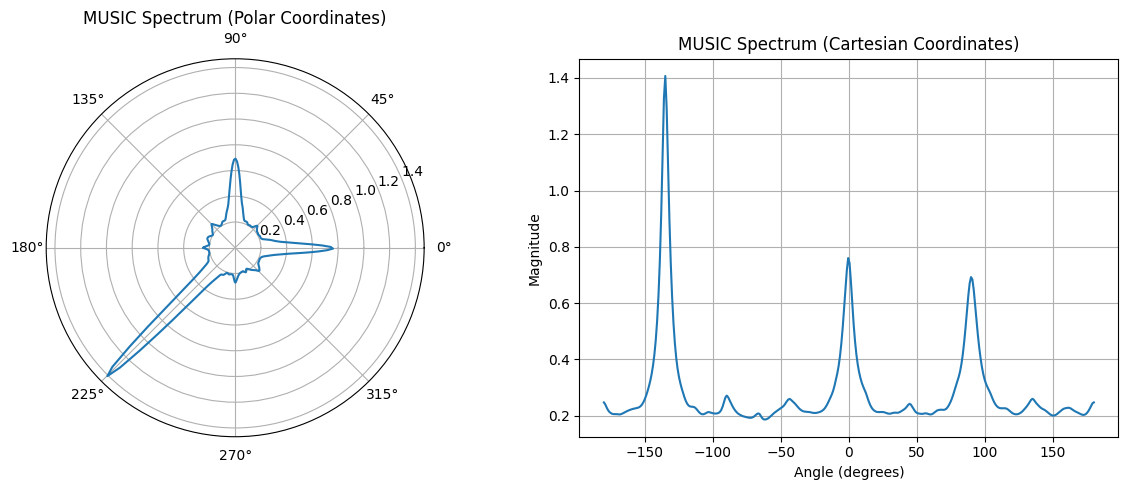

In [13]:
room.simulate(snr=-5)
simulated_signals = room.mic_array.signals
write_signal_to_wav(simulated_signals, "hoge.wav", room.fs)

# FFTの長さとホップサイズを定義
nfft = 512
hop_size = nfft // 2

# シミュレートされた信号をフレームに分割し、FFTを計算
num_frames = (simulated_signals.shape[1] - nfft) // hop_size + 1
X = np.empty((simulated_signals.shape[0], nfft // 2 + 1, num_frames), dtype=complex)

for t in range(num_frames):
    frame = simulated_signals[:, t*hop_size:t*hop_size+nfft]
    X[:, :, t] = np.fft.rfft(frame, n=nfft)

# MUSICインスタンスを作成
doa = MUSIC(
    L=mic_positions,
    fs=room.fs,
    nfft=nfft,
    c=343.0,
    num_src=len(sources_positions),
    mode="near",
    azimuth=np.linspace(-np.pi, np.pi, 360)
)

# 3次元配列を使用してMUSIC法を適用
doa.locate_sources(X, freq_range=[300, 3500])

# 推定された方向を取得
estimated_angles = doa.azimuth_recon

print("推定された音源の方向（ラジアン）:", estimated_angles)
print("推定された音源の方向（度）:", np.rad2deg(estimated_angles))
plot_music_spectrum(doa)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

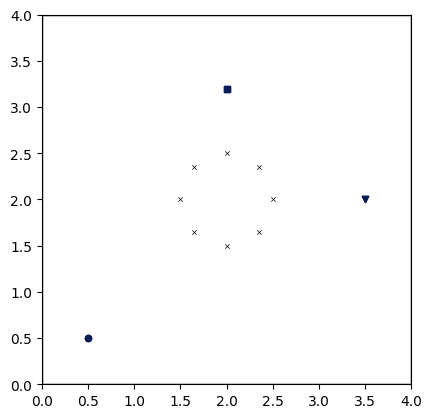

In [14]:
room_dim = [4, 4]
corners = np.array([[0, 0], [0, room_dim[1]], room_dim, [room_dim[0], 0]]).T  # [x,y]

# 2次元の部屋を作成
room = pra.Room.from_corners(
    corners,
    fs=16000,
    max_order=0,
)

# 音源の位置を定義
sources_positions = np.array([[0.5, 0.5], [2, 3.2], [3.5, 2]])

# 音源を部屋に追加
signal = load_signal_from_wav("../data/processed/propeller/p2000_2/dst.wav", room.fs)
samples_per_source = len(signal) // len(sources_positions)
for i, pos in enumerate(sources_positions):
    room.add_source(pos, signal=signal[samples_per_source * i:samples_per_source * (i + 1)])

# マイクロホンアレイの位置を計算
mic_positions = pra.circular_2D_array(center=[2.,2.], M=8, phi0=0, radius=0.5)

# マイクロホンアレイを部屋に追加
mic_array = pra.MicrophoneArray(mic_positions, room.fs)
room.add_microphone_array(mic_array)

room.plot()

推定された音源の方向（ラジアン）: [ 1.56642085  0.00875095 -2.35400675]
推定された音源の方向（度）: [  89.74930362    0.50139276 -134.87465181]


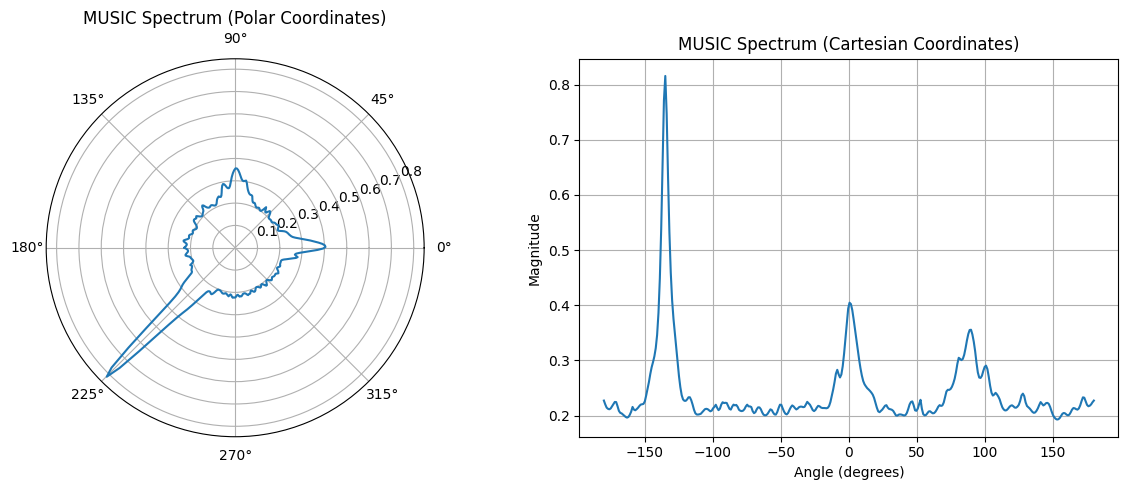

In [15]:
room.simulate(snr=-5)
simulated_signals = room.mic_array.signals
write_signal_to_wav(simulated_signals, "hoge.wav", room.fs)

# FFTの長さとホップサイズを定義
nfft = 512
hop_size = nfft // 2

# シミュレートされた信号をフレームに分割し、FFTを計算
num_frames = (simulated_signals.shape[1] - nfft) // hop_size + 1
X = np.empty((simulated_signals.shape[0], nfft // 2 + 1, num_frames), dtype=complex)

for t in range(num_frames):
    frame = simulated_signals[:, t*hop_size:t*hop_size+nfft]
    X[:, :, t] = np.fft.rfft(frame, n=nfft)

# MUSICインスタンスを作成
doa = MUSIC(
    L=mic_positions,
    fs=room.fs,
    nfft=nfft,
    c=343.0,
    num_src=len(sources_positions),
    mode="near",
    azimuth=np.linspace(-np.pi, np.pi, 360)
)

# 3次元配列を使用してMUSIC法を適用
doa.locate_sources(X, freq_range=[300, 3500])

# 推定された方向を取得
estimated_angles = doa.azimuth_recon

print("推定された音源の方向（ラジアン）:", estimated_angles)
print("推定された音源の方向（度）:", np.rad2deg(estimated_angles))
plot_music_spectrum(doa)

半径は小さい方がよさそう